In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5'
import time

**Parameters for setting up the Simulation**

In [2]:
nx = 32
ny = 32
lx = 1.0
ly = 1.0
dx = lx/nx
dy = ly/ny
ν = 0.01    # Fluid viscosity

**Cell centered grid coordinates**

In [3]:
xc = np.linspace(dx/2.0, lx-dx/2.0, nx)
yc = np.linspace(dy/2.0, ly-dy/2.0, ny)
xxc, yyc = np.meshgrid(xc, yc)

**Staggered grid generation**

In [4]:
# x-staggered grid coordinates for storing x-velocity components (u)
xs = np.linspace(0, lx, nx+1)
xxu, yyu = np.meshgrid(xs, yc)

# y-staggered grid coordinates for storing y-velocity components (v)
ys = np.linspace(0, ly, ny+1)
xxv, yyv = np.meshgrid(xc, ys)

# Plotting the grid for visualization

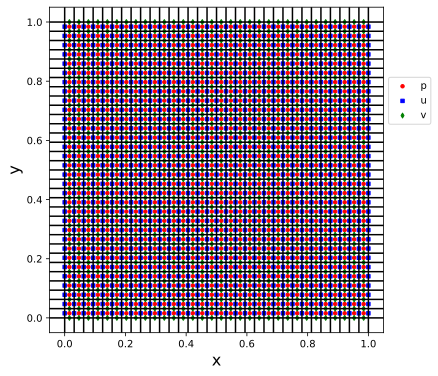

In [5]:
width = 6.0
height = (ly/lx)*width
plt.figure(figsize=(width,height))
plt.xlabel('x',fontsize=16)
plt.ylabel('y',fontsize=16)
plt.xlim(-0.05,lx+0.05)
plt.ylim(-0.05,ly+0.05)
plt.scatter(xxc, yyc, s=12, color='r', marker='o', label='p')
plt.scatter(xxu, yyu, s=12, color='b', marker='s', label='u')
plt.scatter(xxv, yyv, s=12, color='g', marker='d', label='v')
plt.legend(bbox_to_anchor=(1,0.8))

for j in range(len(ys)):
    plt.axvline(ys[j], color='k')
for i in range(len(xs)):
    plt.axhline(xs[i], color='k')

# Driven cavity problem setup

In [6]:
u_top = 1.0
u_bottom = 0.0
v_left = 0.0
v_right = 0.0

**Calculate Reynolds number of the flow based on U, L and $\nu$**

In [7]:
Re = u_top*lx/ν
print(f'Re = {Re}')

Re = 100.0


**Initialize arrays for storing primitive variables $u$, $v$ and $p$**

In [8]:
u = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly
v = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly
p = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly

ut = np.zeros_like(u) # Arrays to store temporary/intermediate velocities
vt = np.zeros_like(v) # Arrays to store temporary/intermediate velocities

**Assembling coefficient matrix for solving Pressure Poisson equation**

In [9]:
Ap = np.zeros([ny+2,nx+2])
Ae = np.ones([ny+2,nx+2])*1.0/dx**2.0
Aw = np.ones([ny+2,nx+2])*1.0/dx**2.0
An = np.ones([ny+2,nx+2])*1.0/dy**2.0
As = np.ones([ny+2,nx+2])*1.0/dy**2.0

# set coefficients for left wall
Aw[1:-1,1] = 0.0
# set coefficients for right wall
Ae[1:-1,-2] = 0.0
# set coefficients for bottom wall
As[1,1:-1] = 0.0
# set coefficients for top wall
An[-2,1:-1] = 0.0
Ap = -(Aw + Ae + An + As)

In [10]:
#Ap

In [11]:
def poisson_solver_Jacobi(p, source, dx, dy):
    pn = np.zeros_like(p)
    J, I = p.shape
    max_iter = 500
    tol = 1e-6
    error = 1.0
    num_iter = 0
    while error > tol and num_iter < max_iter:
        pn = p.copy()
        for j in range(1,ny+1): # J-1
            for i in range(1,nx+1): # I-1
                ap = Ap[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                an = An[j,i]
                aso = As[j,i]
                rhs = source[j,i] - (ae*pn[j,i+1] + aw*pn[j,i-1] + an*pn[j+1,i] + aso*pn[j-1,i])
                p[j,i] = rhs/ap
        error = 0.0
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                error += (p[j,i] - pn[j,i])**2.0
        error = np.sqrt(error)
        #error = np.linalg.norm(p - pn)
        num_iter += 1
    print(f'num_iter = {num_iter}, error = {error}')
    return p

In [12]:
def poisson_solver_GaussSeidel(p, source, dx, dy):
    pn = np.zeros_like(p)
    J, I = p.shape
    max_iter = 500
    tol = 1e-6
    error = 1.0
    num_iter = 0
    while error > tol and num_iter < max_iter:
        pn = p.copy()
        for j in range(1,ny+1): # J-1
            for i in range(1,nx+1): # I-1
                ap = Ap[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                an = An[j,i]
                aso = As[j,i]
                rhs = source[j,i] - (ae*p[j,i+1] + aw*p[j,i-1] + an*p[j+1,i] + aso*p[j-1,i])
                p[j,i] = rhs/ap
        error = 0.0
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                error += (p[j,i] - pn[j,i])**2.0
        error = np.sqrt(error)
        #error = np.linalg.norm(p - pn)
        num_iter += 1
    print(f'num_iter = {num_iter}, error = {error}')
    return p

In [13]:
def poisson_solver_SOR(p, source, dx, dy):
    pn = np.zeros_like(p)
    J, I = p.shape
    max_iter = 100
    tol = 1e-8
    error = 1.0
    num_iter = 0
    β = 1.9
    while error > tol and num_iter < max_iter:
        pn = p.copy()
        for j in range(1,ny+1): #J-1
            for i in range(1,nx+1): #I-1
                ap = Ap[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                an = An[j,i]
                aso = As[j,i]
                rhs = source[j,i] - (ae*p[j,i+1] + aw*p[j,i-1] + an*p[j+1,i] + aso*p[j-1,i])
                p[j,i] = β*rhs/ap + (1.0-β)*p[j,i]
        error = 0.0
        for j in range(1,ny+1):
            for i in range(1,nx+1):
                error += (p[j,i] - pn[j,i])**2.0
        error = np.sqrt(error)
        #error = np.linalg.norm(p - pn)
        num_iter += 1
    print(f'num_iter = {num_iter}, error = {error}')
    return p

## Implementing Chorin's Projection Algorithm

In [14]:
dt = min(0.25*dx*dy/ν, 4.0*ν/u_top**2.0)
print(f'dt = {dt}')

dt = 0.0244140625


In [15]:
def apply_velocity_boundary_conditions(u, v, u_top, u_bottom, v_left, v_right):
    assert u.shape == v.shape
    J, I = u.shape
    
    # u - velocity boundary conditions
    # left & right wall normal velocities
    for j in range(1,ny+1): # J-1
        u[j,1] = 0.0
        u[j,-1] = 0.0
    
    # top and bottom wall tangential velocities
    for i in range(1,nx+2): # I
        u[-1,i] = 2.0*u_top - u[-2,i]    # updating ghost cell velocities
        u[0,i] = 2.0*u_bottom - u[1,i]   # updating ghost cell velocities
    
    # v - velocity boundary conditions
    # left and right wall tangential velocities
    for j in range(1,ny+2): # J
        v[j,0] = 2.0*v_left - v[j,1]
        v[j,-1] = 2.0*v_right - v[j,-2]
    
    # top and bottom wall normal velocities
    for i in range(1,nx+1): # I-1
        v[1,i] = 0.0
        v[-1,i] = 0.0

In [16]:
def solve_x_momentum(u, v, dt, dx, dy):
    J, I = u.shape
    ut = np.zeros_like(u)
    # Update the u-velocities for the interior grid points
    for j in range(1,ny+1): # J-1
        for i in range(2,nx+1): # I-1
            # computing the velocities at the cell faces
            ue = 0.5*(u[j,i] + u[j,i+1])
            uw = 0.5*(u[j,i] + u[j,i-1])
            un = 0.5*(u[j,i] + u[j+1,i])
            us = 0.5*(u[j,i] + u[j-1,i])
            
            vn = 0.5*(v[j+1,i] + v[j+1,i-1])
            vs = 0.5*(v[j,i] + v[j,i-1])
            
            # convective fluxes -d(uu)/dx-d(vu)/dy
            convective_flux = -(ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy
            
            # diffusive fluxes d2u/dx2 + d2u/dy2
            diffusive_flux = ν*( (u[j,i+1] - 2.0*u[j,i] + u[j,i-1])/(dx*dx) + (u[j+1,i] - 2.0*u[j,i] + u[j-1,i])/(dy*dy) )
            
            ut[j,i] = u[j,i] + dt*(convective_flux + diffusive_flux)
    
    return ut

In [17]:
def solve_y_momentum(u, v, dt, dx, dy):
    J, I = v.shape
    vt = np.zeros_like(v)
    # Update the v-velocities for the interior grid points
    for j in range(2,ny+1): # J-1
        for i in range(1,nx+1): # I-1
            # computing the velocities at the cell faces
            ue = 0.5*(u[j,i+1] + u[j-1,i+1])
            uw = 0.5*(u[j,i] + u[j-1,i])
            
            vn = 0.5*(v[j,i] + v[j+1,i])
            vs = 0.5*(v[j,i] + v[j-1,i])
            ve = 0.5*(v[j,i] + v[j,i+1])
            vw = 0.5*(v[j,i] + v[j,i-1])
            
            # convective flux -d(uv)/dx - d(vv)/dy
            convective_flux = -(ue*ve - uw*vw)/dx - (vn*vn - vs*vs)/dy
            
            # diffusive flux - d2v/dx2 + d2v/dy2
            diffusive_flux = ν*( (v[j,i+1] - 2.0*v[j,i] + v[j,i-1])/(dx*dx) + (v[j+1,i] - 2.0*v[j,i] + v[j-1,i])/(dy*dy) )
            
            vt[j,i] = v[j,i] + dt*(convective_flux + diffusive_flux)
    
    return vt

In [18]:
def compute_del_dot_V(ut, vt, dx, dy):
    del_dot_V = np.zeros_like(ut)
    J, I = ut.shape
    
    for j in range(1,ny+1): # J-1
        for i in range(1,nx+1): # I-1
            del_dot_V[j,i] = (ut[j,i+1] - ut[j,i])/dx + (vt[j+1,i] - vt[j,i])/dy
    
    return del_dot_V

In [19]:
def apply_velocity_correction(ut, vt, u, v, p, dx, dy, dt):
    J, I = u.shape
    
    # Correcting u-velocities
    for j in range(1,ny+1): # J-1
        for i in range(2,nx+1): # I-1
            u[j,i] = ut[j,i] - dt*(p[j,i] - p[j,i-1])/dx
    
    # Correcting v-velocties
    for j in range(2,ny+1): # J-1
        for i in range(1,nx+1): # I-1
            v[j,i] = vt[j,i] - dt*(p[j,i] - p[j-1,i])/dy
            
    return u, v

In [20]:
t_final = 1.0
t_current = 0.0
momentum_update_time = 0.0
poisson_solver_time = 0.0
num_time_steps = 0
mass_residual = []

t0 = time.time()
while t_current < t_final:
    apply_velocity_boundary_conditions(u, v, u_top, u_bottom, v_left, v_right)
    tic = time.time()
    ut = solve_x_momentum(u, v, dt, dx, dy)
    vt = solve_y_momentum(u, v, dt, dx, dy)
    source_term = compute_del_dot_V(ut, vt, dx, dy)/dt
    toc = time.time()
    momentum_update_time += toc -tic
    #p = poisson_solver_Jacobi(p, source_term, dx, dy)
    tic = time.time()
    p = poisson_solver_SOR(p, source_term, dx, dy)
    toc = time.time()
    poisson_solver_time += toc - tic
    u, v = apply_velocity_correction(ut, vt, u, v, p, dx, dy, dt)
    residual = np.linalg.norm(compute_del_dot_V(u,v,dx,dy).ravel())
    mass_residual.append(residual)
    t_current += dt
    num_time_steps += 1
    
t_end = time.time()

num_iter = 100, error = 0.0003008687382856553
num_iter = 100, error = 6.576237522920038e-05
num_iter = 100, error = 2.0218430147917717e-05
num_iter = 100, error = 9.95239738567584e-06
num_iter = 100, error = 6.391091127422036e-06
num_iter = 100, error = 4.129950562870558e-06
num_iter = 100, error = 3.150208029714298e-06
num_iter = 100, error = 2.521541787095284e-06
num_iter = 100, error = 2.154016928937443e-06
num_iter = 100, error = 1.917331709193303e-06
num_iter = 100, error = 1.7358471986180489e-06
num_iter = 100, error = 1.6027198857136667e-06
num_iter = 100, error = 1.4891284374387791e-06
num_iter = 100, error = 1.3938271237031118e-06
num_iter = 100, error = 1.3111093029953189e-06
num_iter = 100, error = 1.2361035346861859e-06
num_iter = 100, error = 1.1707712196328183e-06
num_iter = 100, error = 1.1093183457222445e-06
num_iter = 100, error = 1.0554129008112186e-06
num_iter = 100, error = 1.0038550355166205e-06
num_iter = 100, error = 9.581693498406127e-07
num_iter = 100, error = 

In [21]:
total_time = t_end - t0
print(f'Total time : {total_time} s')
print(f'Time per timestep : {total_time/num_time_steps} s')
print(f'Total time for momentum equations : {momentum_update_time} s')
print(f'Total time for solving Poisson equations : {poisson_solver_time} s')
print(f'Poisson solver simulation time fraction : {(poisson_solver_time/total_time)*100} %')

Total time : 12.05708646774292 s
Time per timestep : 0.29407527970104685 s
Total time for momentum equations : 0.45381689071655273 s
Total time for solving Poisson equations : 11.496126651763916 s
Poisson solver simulation time fraction : 95.34746791872337 %


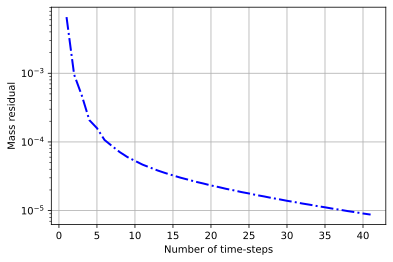

In [22]:
#plt.plot(np.linspace(1,num_time_steps,len(mass_residual)),mass_residual,'b-.',lw=2);
plt.semilogy(np.linspace(1,num_time_steps,len(mass_residual)),mass_residual,'b-.',lw=2)
plt.xlabel('Number of time-steps')
plt.ylabel('Mass residual')
plt.grid(True)

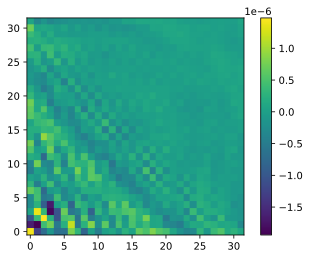

In [23]:
divU = compute_del_dot_V(u, v, dx, dy)
plt.imshow(divU[1:-1,1:-1], origin='lower')
plt.colorbar()

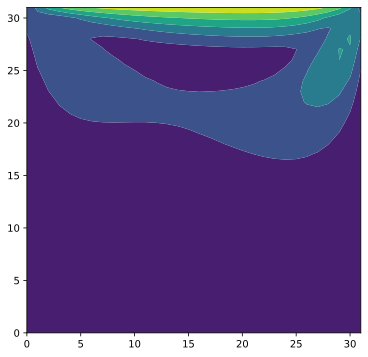

In [24]:
fig = plt.figure(figsize=[6,6],dpi=600)
ucc = 0.5*(u[1:-1,2:] + u[1:-1,1:-1])
vcc = 0.5*(v[2:,1:-1] + v[1:-1,1:-1])
speed = np.sqrt(ucc*ucc + vcc*vcc)
plt.contourf(speed)

## Using Scipy Sparse Iterative Solvers for Poisson Equation

In [25]:
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg

**Assembling coefficient matrix**

In [26]:
Ap = np.zeros([ny,nx])
Ae = np.ones([ny,nx])*(1.0/dx**2.0)
Aw = np.ones([ny,nx])*(1.0/dx**2.0)
An = np.ones([ny,nx])*(1.0/dy**2.0)
As = np.ones([ny,nx])*(1.0/dy**2.0)

# set coefficients for left wall
Aw[:,0] = 0.0
# set coefficients for right wall
Ae[:,-1] = 0.0
# set coefficients for bottom wall
As[0,:] = 0.0
# set coefficients for top wall
An[-1,:] = 0.0
Ap = -(Aw + Ae + An + As)

**Creating diagonals for sparse matrix**

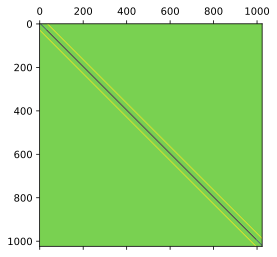

In [27]:
n = nx*ny
# Create main diagonal
d0 = Ap.reshape(n)
# Create remaining diagonal
de = Ae.reshape(n)[:-1]
dw = Aw.reshape(n)[1:]
ds = As.reshape(n)[nx:]
dn = An.reshape(n)[:-nx]

# Creating sparse matrix
A1 = scipy.sparse.diags([d0,de,dw,dn,ds],[0,1,-1,nx,-nx],format='csr')
plt.matshow(A1.toarray())

In [28]:
def scipy_spsolve(A1,source_term):
    pt = scipy.sparse.linalg.spsolve(A1,source_term[1:-1,1:-1].ravel())
    p = np.zeros_like(source_term)
    p[1:-1,1:-1] = pt.reshape([ny,nx])
    return p

In [29]:
def scipy_bicg_solver(A1,source_term):
    pt, info = scipy.sparse.linalg.bicg(A1,source_term[1:-1,1:-1].ravel(),tol=1e-12)
    p = np.zeros_like(source_term)
    p[1:-1,1:-1] = pt.reshape([ny,nx])
    return p

**Initializing arrays for storing primitive variables $u$, $v$ and $p$**

In [30]:
u = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly
v = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly
p = np.zeros([ny+2,nx+2]) # include ghost cells @ x=0, x = lx and y = 0, y = ly

ut = np.zeros_like(u) # Arrays to store temporary/intermediate velocities
vt = np.zeros_like(v) # Arrays to store temporary/intermediate velocities

In [31]:
t_final = 1.0
t_current = 0.0
momentum_update_time = 0.0
poisson_solver_time = 0.0
num_time_steps = 0
mass_residual = []

t0 = time.time()
while t_current < t_final:
    apply_velocity_boundary_conditions(u, v, u_top, u_bottom, v_left, v_right)
    tic = time.time()
    ut = solve_x_momentum(u, v, dt, dx, dy)
    vt = solve_y_momentum(u, v, dt, dx, dy)
    source_term = compute_del_dot_V(ut, vt, dx, dy)/dt
    toc = time.time()
    momentum_update_time += toc -tic
    tic = time.time()
    p = scipy_spsolve(A1,source_term)
    #p = scipy_bicg_solver(A1,source_term)
    toc = time.time()
    poisson_solver_time += toc - tic
    u, v = apply_velocity_correction(ut, vt, u, v, p, dx, dy, dt)
    residual = np.linalg.norm(compute_del_dot_V(u,v,dx,dy).ravel())
    mass_residual.append(residual)
    t_current += dt
    num_time_steps += 1

t_end = time.time()

In [32]:
total_time = t_end - t0
print(f'Total time : {total_time} s')
print(f'Time per timestep : {total_time/num_time_steps} s')
print(f'Total time for momentum equations : {momentum_update_time} s')
print(f'Total time for solving Poisson equations : {poisson_solver_time} s')
print(f'Poisson solver simulation time fraction : {(poisson_solver_time/total_time)*100} %')

Total time : 0.7149944305419922 s
Time per timestep : 0.017438888549804688 s
Total time for momentum equations : 0.45299577713012695 s
Total time for solving Poisson equations : 0.1570146083831787 s
Poisson solver simulation time fraction : 21.96025614691234 %


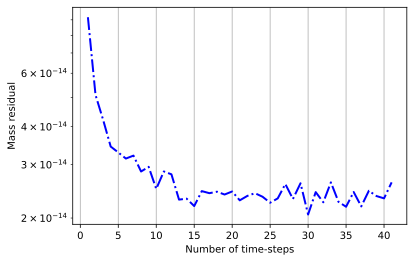

In [33]:
plt.semilogy(np.linspace(1,num_time_steps,len(mass_residual)),mass_residual,'b-.',lw=2)
plt.xlabel('Number of time-steps')
plt.ylabel('Mass residual')
plt.grid(True)

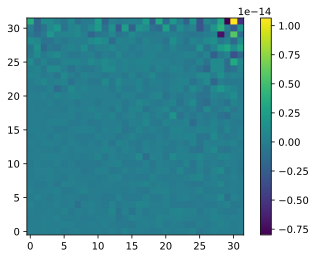

In [34]:
divU = compute_del_dot_V(u, v, dx, dy)
plt.imshow(divU[1:-1,1:-1], origin='lower')
plt.colorbar()

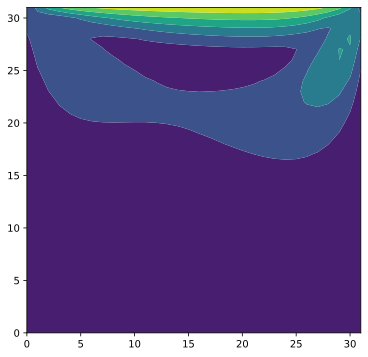

In [35]:
fig = plt.figure(figsize=[6,6],dpi=600)
ucc = 0.5*(u[1:-1,2:] + u[1:-1,1:-1])
vcc = 0.5*(v[2:,1:-1] + v[1:-1,1:-1])
speed = np.sqrt(ucc*ucc + vcc*vcc)
plt.contourf(speed)